In [716]:
author="akash"
date = 'Aug 18,2023'

### Dataset can be downloaded from https://www.unb.ca/cic/datasets/ids-2017.html or you can directly below shell
You need to just unzip and put it same directory with this CNN.ipynb file

### Download dataset directly and unzip

In [717]:
# !gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
# !unzip MachineLearningCSV.zip

In [718]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
%load_ext autoreload

import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time
from torchsummary import summary
from collections import defaultdict

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set dataset path

In [719]:
dataroot = './NewDataset/'

In [720]:
def read_data(dataroot,file_ending='*.pcap_ISCX.csv'):
    if file_ending==None:
        print("please specify file ending pattern for glob")
        exit()
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    print(filenames)
    combined_csv = pd.concat([pd.read_csv(f,dtype=object) for f in filenames],sort=False)
    return combined_csv

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

# reads csv file and returns np array of X,y -> of shape (N,D) and (N,1)
def load_data(dataroot):
    data = read_data(dataroot,'*.csv')
    num_records,num_features = data.shape
    print("There are {} flow records with {} feature dimension".format(num_records,num_features))
    print('Data loaded.\nData preprocessing started...')
    # there is white spaces in columns names e.g. ' Destination Port'
    # So strip the whitespace from  column names
    data = data.rename(columns=lambda x: x.strip())
    print('Stripped column names with whitespaces')

    df_label = data['Label']
    data = data.drop(columns=['Flow Packets/s','Flow Bytes/s','Label'])
    print('remove unnecessary columns: ',['Flow Packets/s','Flow Bytes/s','Label'])
    
    nan_count = data.isnull().sum().sum()
    print('There are {} nan entries'.format(nan_count))
    
    if nan_count>0:
        data.fillna(data.mean(), inplace=True)
        print('Filled NAN')

    data = data.astype(float).apply(pd.to_numeric)
    print('Converted to numeric')
    
    # lets count if there is NaN values in our dataframe( AKA missing features)
    assert data.isnull().sum().sum()==0, "There should not be any NaN"
    X = data.values
    y = encode_label(df_label.values)
    return (X,y)

In [721]:
%autoreload 2
X,y = load_data(dataroot) # reads csv file and returns np array of X,y -> of shape (N,D) and (N,1)

./NewDataset/*.csv
['./NewDataset/output_file.csv']
There are 9999 flow records with 79 feature dimension
Data loaded.
Data preprocessing started...
Stripped column names with whitespaces
remove unnecessary columns:  ['Flow Packets/s', 'Flow Bytes/s', 'Label']
There are 0 nan entries
Converted to numeric


## Data Imbalance
1. It is curucial to adress this issue in order to get decent performance
2. It also affects evaluation, we should calculate  `balanced accuracy`

In [722]:
# normalization
def normalize(data):
    data = data.astype(np.float32)
    eps = 1e-15

    mask = data==-1
    data[mask]=0
    mean_i = np.mean(data,axis=0)
    min_i = np.min(data,axis=0) #  to leave -1 (missing features) values as is and exclude in normilizing
    max_i = np.max(data,axis=0)

    r = max_i-min_i+eps
    data = (data-mean_i)/r  # zero centered 

    #deal with missing features -1
    data[mask] = 0        
    return data

In [723]:
X = normalize(X)

Set random seed

In [724]:
SEED = 42

#### X and y dataset shapes

In [725]:
print(X.shape)
print(y.shape)

(9999, 76)
(9999,)


In [726]:
NUM_QUBITS = 4
NUM_SHOTS = 1024
from qiskit import *
import qiskit

import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [727]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qc = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}

        all_qubits = [i for i in range(n_qubits)]
        self.qc.h(all_qubits)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(1, 0)
        self.qc.cx(2, 0)
        self.qc.cx(3, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 1)
        self.qc.cx(3, 2)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k+4], k)

        self.qc.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)


    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i.cpu().data.numpy()
        parameters = {}

        for k in range(2*self.n_qubits):
          parameters[self.thetas[k]] = params[k].item()

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        res =  self.N_qubit_expectation_Z(job.result().get_counts(), self.shots, self.n_qubits)
        return res

In [728]:
circuit = QCNeuron(NUM_QUBITS, Aer.get_backend('aer_simulator', device="GPU"), NUM_SHOTS)
circuit.qc.draw(fold=2000)

┌───┐ ░ ┌────────────┐ ░ ┌───┐┌───┐┌───┐                ░ ┌────────────┐ ░ ┌─┐         
   q_0: ┤ H ├─░─┤ Ry(Theta0) ├─░─┤ X ├┤ X ├┤ X ├────────────────░─┤ Ry(Theta4) ├─░─┤M├─────────
        ├───┤ ░ ├────────────┤ ░ └─┬─┘└─┬─┘└─┬─┘┌───┐┌───┐      ░ ├────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ H ├─░─┤ Ry(Theta1) ├─░───■────┼────┼──┤ X ├┤ X ├──────░─┤ Ry(Theta5) ├─░──╫─┤M├──────
        ├───┤ ░ ├────────────┤ ░        │    │  └─┬─┘└─┬─┘┌───┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─░─┤ Ry(Theta2) ├─░────────■────┼────■────┼──┤ X ├─░─┤ Ry(Theta6) ├─░──╫──╫─┤M├───
        ├───┤ ░ ├────────────┤ ░             │         │  └─┬─┘ ░ ├────────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├─░─┤ Ry(Theta3) ├─░─────────────■─────────■────■───░─┤ Ry(Theta7) ├─░──╫──╫──╫─┤M├
        └───┘ ░ └────────────┘ ░                                ░ └────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                    0  1  2  3

In [729]:
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        
    def forward(self, i):
        self.qc = QCNeuron(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        # print (self, i)
        exp_value = self.qc.run(i[0])
        result = torch.tensor([exp_value],dtype=torch.float32).to(device)
        # print("QuantumLayer, Forward ", result.dtype)
        # self.save_for_backward(result, i)
        return result

    def backward(self, grad_output):
        # forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()

        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = self.qc.run(shift_right)
            expectation_left  = self.qc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients, dtype=torch.float32).to(device)
        # print("QuantumLayer dtype = ", result.dtype)
        return (result.float() * grad_output.float()).T

In [730]:
import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.utils.tensorboard import SummaryWriter
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from enum import Enum
import logging
from os.path import join

class CNN5(nn.Module):
    """ 
    5-layer Convolutional Neural Network Model
    """
    def __init__(self,input_dim,num_classes,device):
        super(CNN5, self).__init__()
        # kernel
        self.input_dim = input_dim
        self.num_classes = num_classes

        conv_layers = []
        conv_layers.append(nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,padding=1)) # ;input_dim,64
        conv_layers.append(nn.BatchNorm1d(64))
        conv_layers.append(nn.ReLU(True))

        conv_layers.append(nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,padding=1)) #(input_dim,128)
        conv_layers.append(nn.BatchNorm1d(128))
        conv_layers.append(nn.ReLU(True))

        conv_layers.append(nn.Conv1d(in_channels=128,out_channels=256,kernel_size=3,padding=1)) #(input_dim,128)
        conv_layers.append(nn.BatchNorm1d(256))
        conv_layers.append(nn.ReLU(True))

        conv_layers.append(nn.Conv1d(in_channels=256,out_channels=256,kernel_size=3,padding=1)) #(input_dim,128)
        conv_layers.append(nn.BatchNorm1d(256))
        conv_layers.append(nn.ReLU(True))

        conv_layers.append(nn.Conv1d(in_channels=256,out_channels=128,kernel_size=3,padding=1)) #(input_dim,128)
        conv_layers.append(nn.BatchNorm1d(128))
        conv_layers.append(nn.ReLU(True))
        
        self.conv = nn.Sequential(*conv_layers).to(device)
        
        fc_layers = []
        fc_layers.append(nn.Linear(input_dim*128,8))
        fc_layers += [QuantumLayer()]
        fc_layers.append(nn.Linear(16,4))
        fc_layers.append(nn.Linear(4,2))
        self.classifier = nn.Sequential(*fc_layers).to(device)
        
    def forward(self, x):
        batch_size, D = x.shape
        x = x.view(batch_size,1,D)

        x = self.conv(x)
        x = torch.flatten(x,1)
        # print ("flatten - out of Flatten - ", x.dtype)
        x = self.classifier(x)
        return x


In [731]:
class Method(Enum):
    CNN5 = "cnn5"

class Classifier:
    def __init__(self,method,input_dim,num_classes,num_epochs,batch_size=100,lr=1e-3,reg=1e-5,runs_dir=None,seed=10):
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = lr
        self.reg= reg
        self.runs_dir = runs_dir
        self.seed = seed
        #self.device = 'cuda'
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.DEBUG)
        file_handler = logging.FileHandler('training.log')
        file_handler.setLevel(logging.DEBUG)
        file_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(file_formatter)
        self.logger.addHandler(file_handler)
        self.logger.info("Classifier initialized with method %s, input_dim %d, num_classes %d, num_epochs %d, batch_size %d, lr %f, reg %f, runs_dir %s" % (method,input_dim,num_classes,num_epochs,batch_size,lr,reg,runs_dir))
        
        #self.model = nn.Linear(self.input_size, self.num_classes).to(self.device)       
        if method==Method.CNN5.value:
            self.device = torch.device('cpu')
            self.model = CNN5(input_dim,num_classes=num_classes,device=self.device)    
        else:
            raise ValueError("Method must be one of 'softmax', 'cnn2', 'cnn5', 'nn3', or 'nn5'.")
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.learning_rate,betas=(0.9,0.99),eps=1e-08, weight_decay=self.reg, amsgrad=False)

    def fit(self,X,Y):
        self.logger.info('Starting training process...')
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=self.seed)
        for dev_index, val_index in sss.split(X, Y): # runs only once
                X_dev = X[dev_index]
                Y_dev = Y[dev_index]
                X_val = X[val_index]
                Y_val = Y[val_index]  
        
        writer = SummaryWriter(self.runs_dir) 

        tensor_x = torch.stack([torch.Tensor(i) for i in X_dev]).to(self.device)
        tensor_y = torch.LongTensor(Y_dev).to(self.device) # checked working correctly

        dataset = utils.TensorDataset(tensor_x,tensor_y)        
        train_loader = utils.DataLoader(dataset,batch_size=self.batch_size) 
        N = tensor_x.shape[0]

        num_epochs = self.num_epochs

        model  = self.model
        best_acc = None
        best_epoch = None

        filepath = join(self.runs_dir,'checkpoint.pth')
        if os.path.isfile(filepath):
            checkpoint = self.load_checkpoint(filepath)
            best_epoch = checkpoint['epoch']
            best_batch = checkpoint['batch']
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            pred = self.predict(X_val)
            best_acc = metrics.balanced_accuracy_score(Y_val,pred)*100
            resume_epoch = best_epoch+1  
            resume_batch = best_batch+1
        else:
            resume_epoch = 0
            resume_batch = 0
            best_acc = -1
            best_epoch = 0

        no_improvement = 0
        for epoch in range(resume_epoch,num_epochs):
            for i,(xi,yi) in enumerate(train_loader):
                if epoch==resume_epoch and i<resume_batch:
                    continue
                    
                outputs = model(xi)
                loss = self.criterion(outputs,yi)

                loss.requires_grad
                seen_so_far = self.batch_size*(epoch*len(train_loader)+i+1) # fixes issues with different batch size
                writer.add_scalar('Loss/train',loss.item(),seen_so_far)
                #batckward, optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if (seen_so_far/self.batch_size)%800==0:
                    pred = self.predict(X_val)
                    balanced_acc = metrics.balanced_accuracy_score(Y_val,pred)*100
                    if balanced_acc > best_acc:
                        best_acc = balanced_acc
                        best_epoch = epoch
                        checkpoint = {
                        'state_dict': model.state_dict(),
                        'optimizer' : self.optimizer.state_dict(),
                        'epoch':epoch,
                        'batch': i,
                        'batch_size': self.batch_size
                        }
                        self.save(checkpoint)
                        no_improvement =0
                    else:
                        no_improvement+=1
                        if no_improvement>=10:
                            self.logger.warning("No improvement in accuracy for 10 iterations.")
                            return
                    self.logger.debug('Epoch [%d/%d], Step [%d/%d], Loss: %.4f', epoch+1, num_epochs, i+1, len(Y_dev)//self.batch_size, loss.item())


                    writer.add_scalar('Accuracy/Balanced Val',balanced_acc,seen_so_far)

                    acc = metrics.accuracy_score(Y_val,pred)*100
                    writer.add_scalar('Accuracy/Val',acc,seen_so_far)
        writer.close()

    def predict(self,x,eval_mode=False):
        tensor_x = torch.stack([torch.Tensor(i) for i in x]).to(self.device)
        bs = self.batch_size
        num_batch = x.shape[0]//bs +1*(x.shape[0]%bs!=0)

        pred = torch.zeros(0,dtype=torch.int64).to(self.device)
        
        if eval_mode:
            model = self.load_model()
        else:
            model = self.model
        model.eval()        
        
        with torch.no_grad():
            for i in range(num_batch):
                xi = tensor_x[i*bs:(i+1)*bs]
                outputs = model(xi)
                _, predicted_labels = torch.max(outputs.data,1)
                pred = torch.cat((pred,predicted_labels))

        return pred.cpu().numpy()


    def save(self,checkpoint):
        path = join(self.runs_dir,'checkpoint.pth')
        torch.save(checkpoint,path)

    
    def load_checkpoint(self,filepath):
        if os.path.isfile(filepath):
            checkpoint = torch.load(filepath)
            print("Loaded {} model trained with batch_size = {}, seen {} epochs and {} mini batches".
                format(self.runs_dir,checkpoint['batch_size'],checkpoint['epoch'],checkpoint['batch'])) 
            return checkpoint
        else:
            return None
        
            
    def load_model(self,inference_mode=True):
        filepath = join(self.runs_dir,'checkpoint.pth')
        checkpoint = self.load_checkpoint(filepath)
        
        model = self.model
        model.load_state_dict(checkpoint['state_dict'])
        
        if inference_mode:
            for parameter in model.parameters():
                parameter.requires_grad = False
            model.eval()
        return model


In [732]:
def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def getClassifier(args,runs_dir=None):
    (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    clf = Classifier(method,input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,
                        batch_size=batch_size,runs_dir=runs_dir)
    return clf


In [733]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
K=5
skf = StratifiedKFold(n_splits=K,random_state=SEED, shuffle=True)
for fold_index, (train_index,test_index) in enumerate(skf.split(X,y)):# runs only once 
        print('---------------------------------------------')
        print('Fold #{}'.format(fold_index))    
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        break

---------------------------------------------
Fold #0


In [734]:
import torch 
torch.set_num_threads(50)

In [735]:
#We balance data as follows:
#1) oversample small classes so that their population/count is equal to mean_number_of_samples_per_class
#2) undersample large classes so that their count is equal to mean_number_of_samples_per_class
def balance_data(X,y,seed):
    np.random.seed(seed)
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = int(round(np.mean(counts)))
    N,D = X.shape #(number of examples, number of features)
    new_X = np.empty((0,D)) 
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class) # gets `mean_samples_per_class` indices of class `c`
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0) # now we put new data into new_X 
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)
        
    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)

In [736]:
NUM_SHOTS = 750
SHIFT = np.pi/4

SIMULATOR = Aer.get_backend('aer_simulator')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [737]:
#hyper-params
batch_size = 1#5*1024 # increasing batch size with more gpu added
optim = 'Adam'

input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))
print (num_class)
num_epochs = 20
learning_rates = [1e-3]
regularizations = [1e-3]

accuracies = {}
best_model = None
best_acc = -1
architecture = '1D-CNN_conv_5_fc_1'
run_number = 5
method='cnn5'

for lr in learning_rates:
    for reg in regularizations:
        print (reg, lr)
        classifier_args = (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs)
        config =  '{}/{}th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(architecture,run_number,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        print ('balancing data ...')
        X_train,y_train = balance_data(X_train,y_train,seed=SEED)
        
        tick = time.time()
        clf = getClassifier(classifier_args,runs_dir)
        print ('Fit data to model.')

        clf.fit(X_train,y_train)
        pred = clf.predict(X_test,eval_mode=True)
        
        print ('Try prediction .. ')
        acc = metrics.balanced_accuracy_score(y_test,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc
        tock = time.time()
        print("Model is trained in {} sec".format(tock-tick))

2
0.001 0.001
balancing data ...
Fit data to model.


/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using 

Loaded ./NewDataset/runs/1D-CNN_conv_5_fc_1/5th_run/optim_Adam_lr_0.001_reg_0.001_bs_1 model trained with batch_size = 1, seen 2 epochs and 799 mini batches


/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Try prediction .. 
Model is trained in 890.9492890834808 sec


In [738]:
len(np.unique(y_train))

2

In [739]:
# accuracies for CV
for x in accuracies:
    print(x)
    print(accuracies[x])
results = accuracies  

(0.001, 0.001)
0.9435


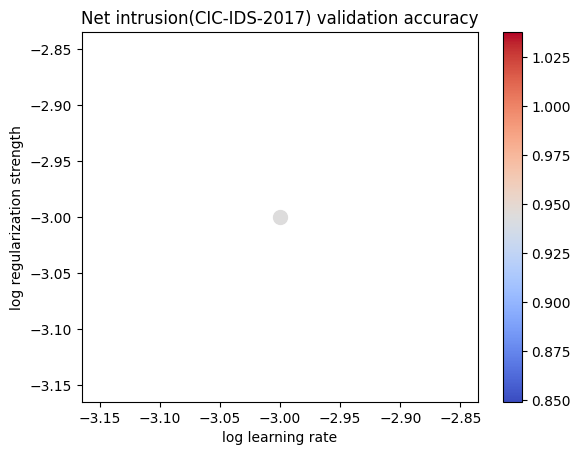

In [740]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
plt.savefig('../net_intrusion_detection/method_{}_arch_run_{}-2.png'.format(method,architecture,run_number))
plt.show()

In [741]:
results

{(0.001, 0.001): 0.9435}

In [742]:
from torchsummary import summary
summary(clf.model, (76,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 76]             256
       BatchNorm1d-2               [-1, 64, 76]             128
              ReLU-3               [-1, 64, 76]               0
            Conv1d-4              [-1, 128, 76]          24,704
       BatchNorm1d-5              [-1, 128, 76]             256
              ReLU-6              [-1, 128, 76]               0
            Conv1d-7              [-1, 256, 76]          98,560
       BatchNorm1d-8              [-1, 256, 76]             512
              ReLU-9              [-1, 256, 76]               0
           Conv1d-10              [-1, 256, 76]         196,864
      BatchNorm1d-11              [-1, 256, 76]             512
             ReLU-12              [-1, 256, 76]               0
           Conv1d-13              [-1, 128, 76]          98,432
      BatchNorm1d-14              [-1, 

/tmp/ipykernel_68580/591016902.py:55: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


In [743]:
X_train.shape[1]

76

In [744]:
clf.model

CNN5(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
  )
  (classifier): Sequent